In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

import matplotlib 
if not is_notebook():
    matplotlib.use('Agg')

# set directory
os.chdir("/nas/ucb/oliveradk/diverse-gen/")


In [2]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments
from utils.utils import conf_to_args

In [3]:
SCRIPT_NAME = "spur_corr_exp.py"
EXP_DIR = Path("output/cc_mix_rate_sweep_all")
EXP_DIR.mkdir(parents=True, exist_ok=True)

# Define Configs

In [4]:
# shared configs
BATCH_SIZE = 32 
TARGET_BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-4
OPTIMIZER = "adamw"

# seeds
seeds = [1, 2, 3]

# mix rates
mix_rates = [0.1, 0.25, 0.5, 0.75, 1.0]

# methods 
methods = {
    "DivDis": {"loss_type": LossType.DIVDIS},
    "TopK 0.1": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1}, 
    "TopK 0.5": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5}, 
    "TopK 1.0": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 1.0}, 
    "DBAT": {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "binary": True},
    "ERM": {"loss_type": LossType.ERM}
}
# datasets 
datasets = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": BATCH_SIZE, "target_batch_size": 128, "plot_activations": False},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "cifar_mnist": {"dataset": "cifar_mnist", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "waterbirds": {"dataset": "waterbirds", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "celebA-0": {"dataset": "celebA-0", "epochs": EPOCHS, "lr": LR, "optimizer": OPTIMIZER, "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE},
    "multi-nli":{"dataset": "multi-nli", "model": "bert", "epochs": 2, "lr": 1e-5, "optimizer": OPTIMIZER, "lr_scheduler": "cosine", "batch_size": BATCH_SIZE, "target_batch_size": TARGET_BATCH_SIZE, "combine_neut_entail": True, "contra_no_neg": True},
}

# tuned according to total validatin loss
aux_weight_map = {
    "TopK 0.1": {
        "toy_grid": 1.5,
        "fmnist_mnist": 1.0,
        "cifar_mnist": 1.5,
        "waterbirds": 8,
        "celebA-0": 2.5,
        "multi-nli": 16
    },
    "TopK 0.5": {
        "toy_grid": 1.0,
        "fmnist_mnist": 1.0,
        "cifar_mnist": 1.0,
        "waterbirds": 3.0,
        "celebA-0": 1.5,
        "multi-nli": 1.0
    },
    "TopK 1.0": {
        "toy_grid": 1.0,
        "fmnist_mnist": 1.0,
        "cifar_mnist": 1.0,
        "waterbirds": 5.0,
        "celebA-0": 2.5,
        "multi-nli": 16
    }, 
    "DivDis": {
        "toy_grid": 1.0,
        "fmnist_mnist": 1.5,
        "cifar_mnist": 1.5,
        "waterbirds": 6,
        "celebA-0": 1.5,
        "multi-nli": 64
    }, 
    "DBAT": {
        "toy_grid": 1.0,
        "fmnist_mnist": 1.0,
        "cifar_mnist": 1.0,
        "waterbirds": 1.0,
        "celebA-0": 1.0,
        "multi-nli": 1.0
    }, 
    "ERM": {
        "toy_grid": 1.0,
        "fmnist_mnist": 1.0,
        "cifar_mnist": 1.0,
        "waterbirds": 1.0,
        "celebA-0": 1.0,
        "multi-nli": 1.0
    }
}

lr_optim_map = {
    "TopK 0.1": {
        "toy_grid": (1e-3, "sgd")
    }, 
    "DivDis": {
        "toy_grid": (1e-3, "adamw")
    }
}

configs = {
    (ds_name, method_name, mix_rate, seed): {**ds, **method, "mix_rate": mix_rate, "seed": seed} 
    for (ds_name, ds), (method_name, method), mix_rate, seed in product(datasets.items(), methods.items(), mix_rates, seeds)
}

###  dataset x method adjustments
# aux weight
for ((ds_name, method_name, mix_rate, seed), conf) in configs.items():
    conf["aux_weight"] = aux_weight_map[method_name][ds_name]
# optimizer and lr
for ((ds_name, method_name, mix_rate, seed), conf) in configs.items():
    if method_name in lr_optim_map and ds_name in lr_optim_map[method_name]:
        conf["lr"], conf["optimizer"] = lr_optim_map[method_name][ds_name]




for conf in configs.values():
    if conf["loss_type"] == LossType.DBAT: 
        conf["batch_size"] = int(conf["batch_size"] / 2)
        conf["target_batch_size"] = int(conf["target_batch_size"] / 2)

def get_conf_dir(conf_name: tuple):
    ds, method, mix_rate, seed = conf_name
    return f"{ds}_{method}_{mix_rate}/{seed}"

for conf_name, conf in configs.items():
    conf["exp_dir"] = EXP_DIR / get_conf_dir(conf_name)


In [10]:
# # TODO: remove
# # remove multi-nli 
# configs = {k: v for k, v in configs.items() if v["dataset"] != "multi-nli"}
# toy_grid_configs = {k: v for k, v in configs.items() if v["dataset"] == "toy_grid"}
# dbat_configs = {k: v for k, v in configs.items() if v["loss_type"] == LossType.DBAT}
# configs = {**toy_grid_configs, **dbat_configs}

# Run Experiments

In [5]:
high_mem_ds = ["multi-nli", "celebA-0"]
low_mem_configs = {k: v for k, v in configs.items() if v["dataset"] not in high_mem_ds}
high_mem_configs = {k: v for k, v in configs.items() if v["dataset"] in high_mem_ds}


In [13]:
executor = get_executor(EXP_DIR, mem_gb=16)
jobs = run_experiments(executor, list(low_mem_configs.values()), SCRIPT_NAME)


In [6]:
executor = get_executor(EXP_DIR, mem_gb=32)
jobs = run_experiments(executor, list(high_mem_configs.values()), SCRIPT_NAME)                

# Process Results

In [5]:
from typing import Literal
def get_exp_metrics(conf: dict):
    if not (conf["exp_dir"] / "metrics.json").exists():
        raise FileNotFoundError(f"Metrics file not found for experiment {conf['exp_dir']}")
    with open(conf["exp_dir"] / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

def get_max_acc(
    exp_metrics: dict,
    acc_metric: Literal["test_acc", "test_worst_acc", "test_acc_alt"]="test_acc",
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc"
):
    max_accs = np.maximum(np.array(exp_metrics[f'{acc_metric}_0']), np.array(exp_metrics[f'{acc_metric}_1']))
    if model_selection == "acc": 
        max_acc_idx= np.argmax(max_accs)
    elif model_selection == "loss":
        max_acc_idx = np.argmin(exp_metrics["val_loss"])
    elif model_selection == "weighted_loss":
        max_acc_idx = np.argmin(exp_metrics["val_weighted_loss"])
    elif model_selection == "repulsion_loss":
        max_acc_idx = np.argmin(exp_metrics["target_val_weighted_repulsion_loss"])
    else: 
        raise ValueError(f"Invalid model selection: {model_selection}")
    max_acc = max_accs[max_acc_idx]
    return max_acc

# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results(
    exp_configs: list[dict],
    acc_metric: Literal["test_acc", "test_worst_acc", "test_acc_alt"]="test_acc",
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc",
    verbose: bool=False
):
    results = defaultdict(list)
    for conf in exp_configs:
        try:
            exp_metrics = get_exp_metrics(conf)
            max_acc = get_max_acc(exp_metrics, acc_metric, model_selection)
            results[conf["mix_rate"]].append(max_acc)
        except FileNotFoundError:
            if verbose:
                print(f"Metrics file not found for experiment {conf['exp_dir']}")
            continue
    results = dict(results)
    return results

In [6]:
# sort experiments
exps_by_dataset_method = defaultdict(lambda:defaultdict(list))
for (ds_name, method_name, mix_rate, seed), conf in configs.items():
    exps_by_dataset_method[ds_name][method_name].append(conf)

In [25]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

def plot_acc_results(
    results: dict, 
    ignored_loss_types: list[str]=[], 
    figsize: tuple[float, float]=FIGSIZE,
    ylim: tuple[float, float]=(0.5, 1.0), 
    title: Optional[str]=None, 
    fontsize: int=FONTSIZE,
    tick_fontsize: int=TICK_FONTSIZE,
    legend: bool=False, 
):
    # plot mean accuracy with dotted standard deviation for each method type at each mix rate
    fig, ax = plt.subplots(figsize=figsize)
    
    for loss_type, loss_results in results.items():
        if loss_type in ignored_loss_types:
            continue
        
        if isinstance(loss_type, LossType):
            loss_type = loss_type.name 
        
        means = [np.mean(loss_results[mix_rate]) for mix_rate in mix_rates]
        stds = [np.std(loss_results[mix_rate]) for mix_rate in mix_rates]
        line_style = '-'
        marker = 'o'
        if loss_type == LossType.ERM.name:
            results = [loss_results[mix_rate] for mix_rate in mix_rates]
            means = [np.mean(results) for _ in range(len(mix_rates))]
            stds = [np.std(results) for _ in range(len(mix_rates))]
            line_style = '--'
            marker = None
        
        ax.plot(mix_rates, means, label=loss_type, marker=marker, linestyle=line_style)
        ax.fill_between(mix_rates, 
                        [m - s for m, s in zip(means, stds)],
                        [m + s for m, s in zip(means, stds)],
                        alpha=0.2)

    # ax.set_xlabel('Mix Rate', fontsize=fontsize)
    # ax.set_ylabel('Accuracy', fontsize=fontsize)

    # set x ticks to mix rates
    x_labels = [str(mix_rate) for mix_rate in mix_rates]
    ax.set_xticks(mix_rates)
    ax.set_xticklabels(x_labels, fontsize=tick_fontsize)

    # tick fontsize
    ax.tick_params(axis='both', labelsize=tick_fontsize)


    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if legend:
        ax.legend()
    # ax.grid(True, linestyle='--', alpha=0.7)
    # start y axis at 0.75
    ax.set_ylim(*ylim)

    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # remove bottom and left spines
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    fig.tight_layout()
    return fig, ax


In [26]:
ignored_loss_types = ["TopK 1.0"]

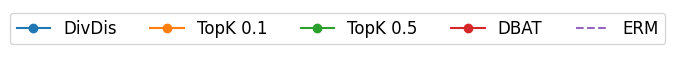

In [27]:
current_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(8, 0.5))
legend_elements = [
    plt.Line2D([0], [0], color=current_colors[i], marker='o' if k != "ERM" else None, linestyle='-' if k != "ERM" else '--', label=k) 
    for i, k in enumerate([k for k in methods.keys() if k not in ignored_loss_types])
]

ax.set_axis_off()


plt.figlegend(handles=legend_elements,
              ncol=len(methods),
             loc='center',
             bbox_to_anchor=(0.5, 0.5),
             fontsize=12,
             frameon=True)

In [28]:
# get average accs (by val loss) for each experiment
acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        acc_results[ds_name][method_name] = get_acc_results(exps, model_selection="loss", acc_metric="test_acc", verbose=False)

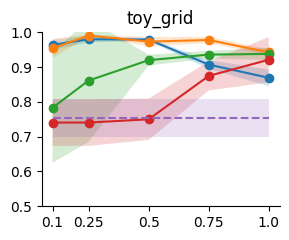

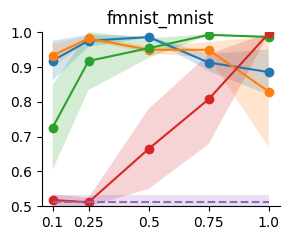

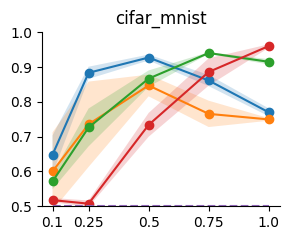

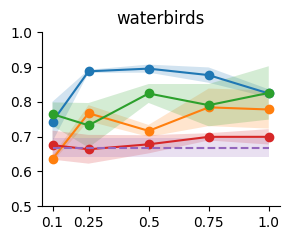

In [29]:
for ds_name, method_dict in acc_results.items():
    if ds_name in ["multi-nli", "celebA-0"]:
        continue
    plot_acc_results(method_dict, title=ds_name, legend=False, ignored_loss_types=ignored_loss_types)


In [30]:
# get average accs (by val loss) for each experiment
alt_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        alt_acc_results[ds_name][method_name] = get_acc_results(exps, model_selection="loss", acc_metric="test_acc_alt")

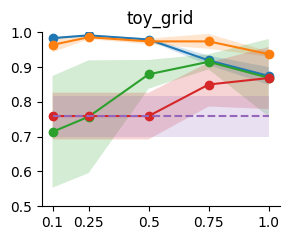

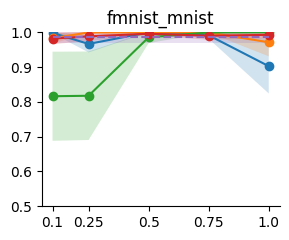

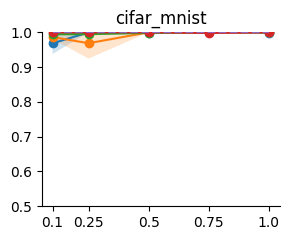

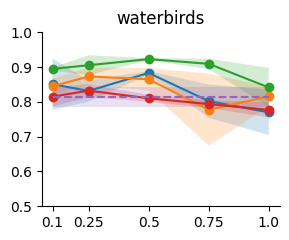

In [31]:
for ds_name, method_dict in alt_acc_results.items():
    if ds_name in ["multi-nli", "celebA-0"]:
        continue
    plot_acc_results(method_dict, title=ds_name, legend=False, ignored_loss_types=ignored_loss_types)

In [32]:
# get average accs (by val loss) for each experiment
worst_acc_results = defaultdict(lambda:defaultdict(list))
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        worst_acc_results[ds_name][method_name] = get_acc_results(exps, model_selection="loss", acc_metric="test_worst_acc", verbose=False)

rember to note that we believe the worse performance of DivDis is largely due 
to the validation data not being shufled (and also using the full validation set for training, rather than 
using a split)

key takeaways: 
- performance of DivDis peaks at 0.5, decreases on either end (but more pronounced at higher mix rates, surprising strong on low mix rates)
- performance of DBAT peaks at mix rates of 1.0, but degrades substantially at lower mix rates
    - we believe prior work engaginged in unprincipled hyperparameter tuning (in particular of the auxilary weight loss), artifically inflating peformance
    - dbat also tends to perform better with more extreme simplicity bias, because stagewise learning means must learn a "clean" representation of the spurious feature first
- topk 0.1 performs well sometimes (toy grid, fmnist_mnist) but may be less sample efficient and more unstable (possibly because it can more easily memorize a small number of examples / pick up on other unrelated features)
- topk performances well on mix rates >= 0.5 (often outperforming DivDis), but tends to perform poorly on lower mix rates (makes sense, necessarily mislabeled instances)

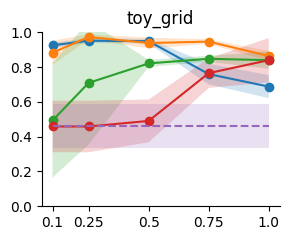

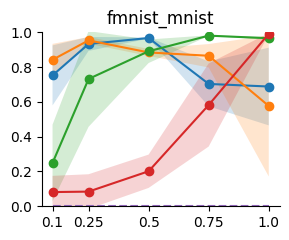

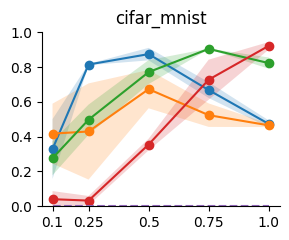

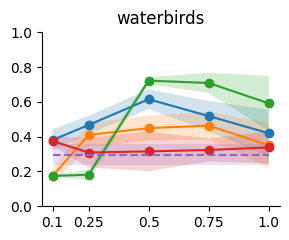

In [33]:
for ds_name, method_dict in worst_acc_results.items():
    if ds_name in ["multi-nli", "celebA-0"]:
        continue
    plot_acc_results(method_dict, title=ds_name, legend=False, ylim=(0.0, 1.0), ignored_loss_types=ignored_loss_types)